# 2.7.2: Glucose (Solving IVPs)

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [1]:
#@title
# Import necessary libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
import pandas as pd
import numpy as np

Downloaded ModSimPy_Functions/modsim.py


In this notebook, we'll implement the minimal model in two ways by rewriting the differential equations as difference equations; then we'll solve the difference equations using a version of `run_simulation` similar to what we have used in previous chapters. 

First, though, we'll download the glucose and insulin data:

In [2]:

filename = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Data/glucose_insulin.csv'
# If you are using this notebook offline, you will need to upload this data
# from the Images_and_Data folder.  Comment out the line above, and uncomment the
# line below this one, and run this cell
# filename = '../Images_and_Data/Data/glucose_insulin.csv'

data = pd.read_csv(filename, index_col='time')

## Using a Time Step Loop

### Making a System and a State

Here's a version of `make_system` that takes `params` and `data` as parameters.  Notice that we are setting the base values of glucose and insulin here by assuming that the patient is at these base levels just before the injection.

In [3]:
def make_system(G0, k1, k2, k3, dt, data):
    t_0 = data.index[0]
    t_end = data.index[-1]
    
    # Assuming that the patient levels are at equilibrium
    # before the injection
    Gb = data.glucose[t_0]
    Ib = data.insulin[t_0]
    
    # Creating the function I to evaluate insulin at any time step
    # The insulin level as a function of time is an input into this
    # model, rather than a variable like G and X
    I = interp1d(data.insulin.index,data.insulin.values)

    # The system needs an attribute called 'init' because we'll
    # use that with "solve_ivp" later in the notebook
    state = pd.Series(dict(G=G0, X=0),dtype=np.float64)
    system = dict(init=state,
                  k1=k1,k2=k2,
                  k3=k3,dt=dt,
                  Gb=Gb, Ib=Ib, I=I,
                  t_0=t_0, t_end=t_end)
    
    return system, state


`make_system` gets `t_0` and `t_end` from the data, and it uses the parameter `G0` as the initial value for `G`. Then it 
returns both a state object (a `Series`) and a system object (a `dictionary`).   We'll make some assumptions here to set the parameters:

In [4]:
G0 = 270
k1 = 0.02
k2 = 0.02
k3 = 1.5e-05
dt = 2
system, state = make_system(G0, k1, k2, k3, dt, data)


### Defining a Change Function

The minimal model is expressed in terms of differential equations:

<br>

$$\frac{dG}{dt} = -k_1 \left[ G(t) - G_b \right] - X(t) G(t)$$

<br>

$$\frac{dX}{dt} = k_3 \left[I(t) - I_b \right] - k_2 X(t)$$ 

<br>

To simulate this system, we will rewrite them as difference equations. 
If we multiply both sides by $dt$, as we have done before, we have:

<br>

$$dG = \left[ -k_1 \left[ G(t) - G_b \right] - X(t) G(t) \right] dt$$

<br>

$$dX = \left[ k_3 \left[I(t) - I_b \right] - k_2 X(t) \right] dt$$ 

<br>

If we think of $dt$ as a small step in time, these equations tell us how to compute the corresponding changes in $G$ and $X$.  Here's an change function that computes these changes:

In [5]:
def change_func(t, state, system):
    
    G, X = state
    k1, k2, k3, dt = system['k1'],system['k2'], system['k3'], system['dt']
    I, Ib, Gb = system['I'], system['Ib'], system['Gb']
    
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X

    state.G += dGdt * dt
    state.X += dXdt * dt

    return state

We've seen code like this before: this function returns the updated state object return value with the new values of `G` and `X`.  Before running the simulation, it is a good idea to run the change function with the initial conditions:

In [6]:
change_func(system['t_0'], state, system)

G    262.88
X      0.00
dtype: float64

If it runs without errors and there is nothing obviously wrong with the results, we are ready to run the simulation. 

✅ Active reading: Add inline documentation to the change_func above.  Add one line of documentation for each section of code.

### Simulating Glucose Levels

We'll use the following version of `run_simulation`:

In [7]:
def run_simulation(system, state, change_func):  
    t_array = np.arange(system['t_0'], system['t_end']+1, system['dt'])
    n = len(t_array)
    
    frame = pd.DataFrame(index=t_array, 
                      columns=state.index,
                        dtype=np.float64)
    frame.iloc[0] = state
    
    for i in range(n-1):
        t = t_array[i]
        frame.iloc[i+1] = change_func(t, state, system)
    
    return frame

Notice that we are storing the state ($G$ and $X$) at each time step with a `DataFrame`, rather than with two `Series`. When we make the `DataFrame`, we use `index` to indicate that the index is the array of time stamps, `t_array`, and `columns` to indicate that the column names are the state variables we get from index of the state object.

<br>

We can run it like this, and it returns a `DataFrame` with a row for each time step and a column for each of the state variables, `G` and `X`.

In [8]:
system, state = make_system(G0, k1, k2, k3, dt, data)
results = run_simulation(system, state,change_func)
results.head()

,G,X
0,270.000000,0.000000
2,262.880000,0.000000
4,256.044800,0.000450
6,249.252568,0.004002
8,240.967447,0.006062


The following plot shows the simulated glucose levels from the model along with the measured data. 

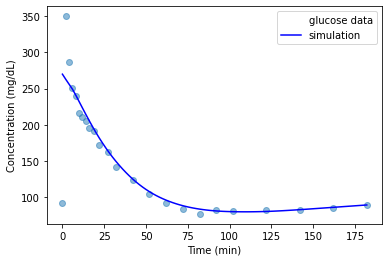

In [13]:
data.glucose.plot(style='o', alpha=0.5, label='glucose data',legend=True)
results.G.plot(style='-', color='blue', label='simulation',legend=True,
               xlabel='Time (min)',
               ylabel='Concentration (mg/dL)');

With the parameters we chose, the model fits the data well except during the first few minutes after the injection.
But we don't expect the model to do well in this part of the time series.  The problem is that the model is *non-spatial*; that is, it does not
take into account different concentrations in different parts of the
body. Instead, it assumes that the concentrations of glucose and insulin in blood, and insulin in tissue fluid, are the same throughout the body. This way of representing the body is known among experts as the "bag of blood" model.

<br>

Immediately after injection, it takes time for the injected glucose to
circulate. During that time, we don't expect a non-spatial model to be
accurate. For this reason, we should not take the estimated value of `G0` too seriously; it is useful for fitting the model, but not meant to correspond to a physical, measurable quantity.

### Simulating the Level of Insulin in the Tissue

Remember that $I$ represents the insulin levels in the blood, while $X$ represents the levels in the tissue fluid, where it actually does the work of reducing glucose.  The following plot shows simulated insulin levels $X$ in the tissue, which is in unspecified units:

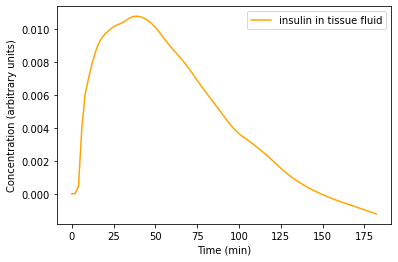

In [12]:
results.X.plot(color='orange', label='insulin in tissue fluid',
               xlabel='Time (min)', 
               ylabel='Concentration (arbitrary units)',
               legend=True);

Remember that `X` represents the concentration of insulin in the "remote compartment", which is believed to be tissue fluid, so we can't compare it to the measured concentration of insulin in the blood.  `X` rises quickly after the initial injection and then declines as the concentration of glucose declines.  Qualitatively, this behavior is as expected, but because `X` is not an observable quantity, we can't validate this part of the model quantitatively.

### Exercise 1

There are two terms on the right hand side of the equation for $G$ (glucose):

<br>$$\frac{dG}{dt} = -k_1 \left[ G(t) - G_b \right] - X(t) G(t)$$

<br> Look at the plot above of $G$ (the blue one).  From 0-25 s, the level of $G$ decreases very quickly.Remembering that all the $k$ constants are positive, which of the right hand side terms (or both?) is driving the glucose down in the first part of the model?  Consider the signs of the term (negative/ positive), and the size of $G(t)$ and $X(t)$ during that time period. 

✅ ✅  Answer here

### Exercise 2

There are two terms on the right hand side of the equation for $X$ (insulin in the tissue):

<br> $$\frac{dX}{dt} = k_3 \left[I(t) - I_b \right] - k_2 X(t)$$ 

<br> Look at the plot above (the orange one).  From 0-25 s, the level of $X$ increases very quickly.  Which of the two terms is responsible for driving the rapid increase in $X$ in the first part of the simulation?  Consider the signs of the term (negative/ positive), and the size of $I$ and $X$ during that time period.

✅ ✅  Answer here